In [7]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from util import optimiser
import scipy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

In [2]:
cost_coefs = pd.read_csv("cost_function_coeffs.csv")
cost_coefs.head()

,ALPHA,BETA,GAMMA
0,-0.67,2.56,2.51
1,0.02,-2.57,1.31
2,-0.51,-2.10,1.97
3,0.26,-3.30,3.48
4,0.71,-1.45,1.62


In [3]:
def f_mean(*args,**kwargs):
    return np.mean(f(*args,**kwargs),axis=0)

def f(x,y,alpha,beta,gamma):
    return x**2+alpha*x**2*y+beta*x*y**2+gamma*x*y
chosen_functions = [0,1,2,4,5,7,9,15,16,18]
N = [10,25,50]

In [18]:
dist_type = "gmm2"

In [34]:
def get_dist(dist_type):
    if dist_type == "beta1":
    # Define the true distribution
        dist = st.beta(a = 2,b=2,loc=-1,scale=2)
    elif dist_type == "beta2":
        # Define the true distribution
        dist = st.beta(a = 5,b=5,loc=-1,scale=2)
    elif dist_type == "beta3":
        # Define the true distribution
        dist = st.beta(a = 2,b=5,loc=-1,scale=2)
    elif "gmm" in dist_type:
            if dist_type=="gmm1":
                mu1=-0.5
                sigma1=0.15
                mu2=0.4
                sigma2=0.3
                p=0.6
            elif dist_type=="gmm2":
                mu1=-0.1
                sigma1=0.3
                mu2=0.4
                sigma2=0.1
                p=0.7
            dist = GaussianMixture(n_components=2,covariance_type="spherical")
            dist.weights_=np.array([p,1-p])
            dist.means_=np.array([[mu1],[mu2]])
            dist.covariances_=np.array([sigma1**2,sigma2**2])
            dist.precisions_cholesky_ =  np.linalg.cholesky(np.linalg.inv([[sigma1**2,0],[0,sigma2**2]]))
    return dist

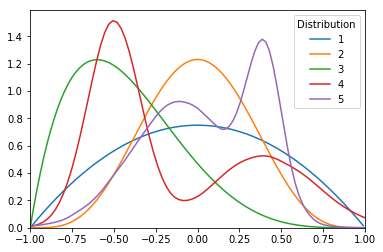

In [70]:
dist_types = ["beta1","beta2","beta3","gmm1","gmm2"]
# plot the pdf within the range
fig, axes = plt.subplots(1, 1)
x = np.arange (-1, 1, 0.01)
for ele in dist_types:
    dist = get_dist(ele)
    if "gmm" in ele:
        z = dist.sample(100000)[0]
        temp = sns.distplot(z, hist=False,ax=axes,label="")
    else:
        z = dist.pdf(x)
        temp = sns.lineplot(x,z,ax=axes,label="")
plt.xlim([-1,1])
axes.legend(("1","2","3","4","5"),title="Distribution")
plt.savefig("distributions.png", bbox_inches = 'tight',
   pad_inches = 0)

In [ ]:
dist = get_dist(dist_type)

In [20]:
df = pd.read_csv(dist_type+"_experiment_results.csv",index_col=0)
for z in range(len(chosen_functions)):
    coefs = cost_coefs.iloc[chosen_functions[z]].values
    new_f = lambda x,y: f_mean(x,y,coefs[0],coefs[1],coefs[2])
    if "gmm" in dist_type:
        samples = dist.sample(100000)[0]
    else:
        samples = dist.rvs(100000)
    saa = optimiser.SAA(new_f)
    w_star = saa.solve(samples,0.0)[0] 
    results = {'w_star': w_star,
               'method':'True',
               'function':chosen_functions[z]+1,
               'N':N[0],
              "distribution":dist_type}
    df = df.append(results,ignore_index=True)
    expected_cost = new_f(w_star,samples)

In [26]:
if "gmm" in dist_type:
        samples = dist.sample(100000)[0]
else:
    samples = dist.rvs(100000)
df['expected_cost'] = 0
for i in range(len(chosen_functions)):
    mask = (df['function'] == chosen_functions[i]+1)
    df_valid = df[mask]
    coefs = cost_coefs.iloc[chosen_functions[i]].values
    new_f = lambda x,y: f_mean(x,y,coefs[0],coefs[1],coefs[2])
    df.loc[mask, 'expected_cost'] = df_valid['w_star'].apply(
                                        lambda x:new_f(x,samples))

In [27]:
df["SAA_compare"] = 0
for i in np.arange(0,df.shape[0]-10,5):
    for k in range(5):
        if k!=2:
            df.loc[i+k,'SAA_compare'] = df.loc[i+2,"expected_cost"]-df.loc[i+k,"expected_cost"] 

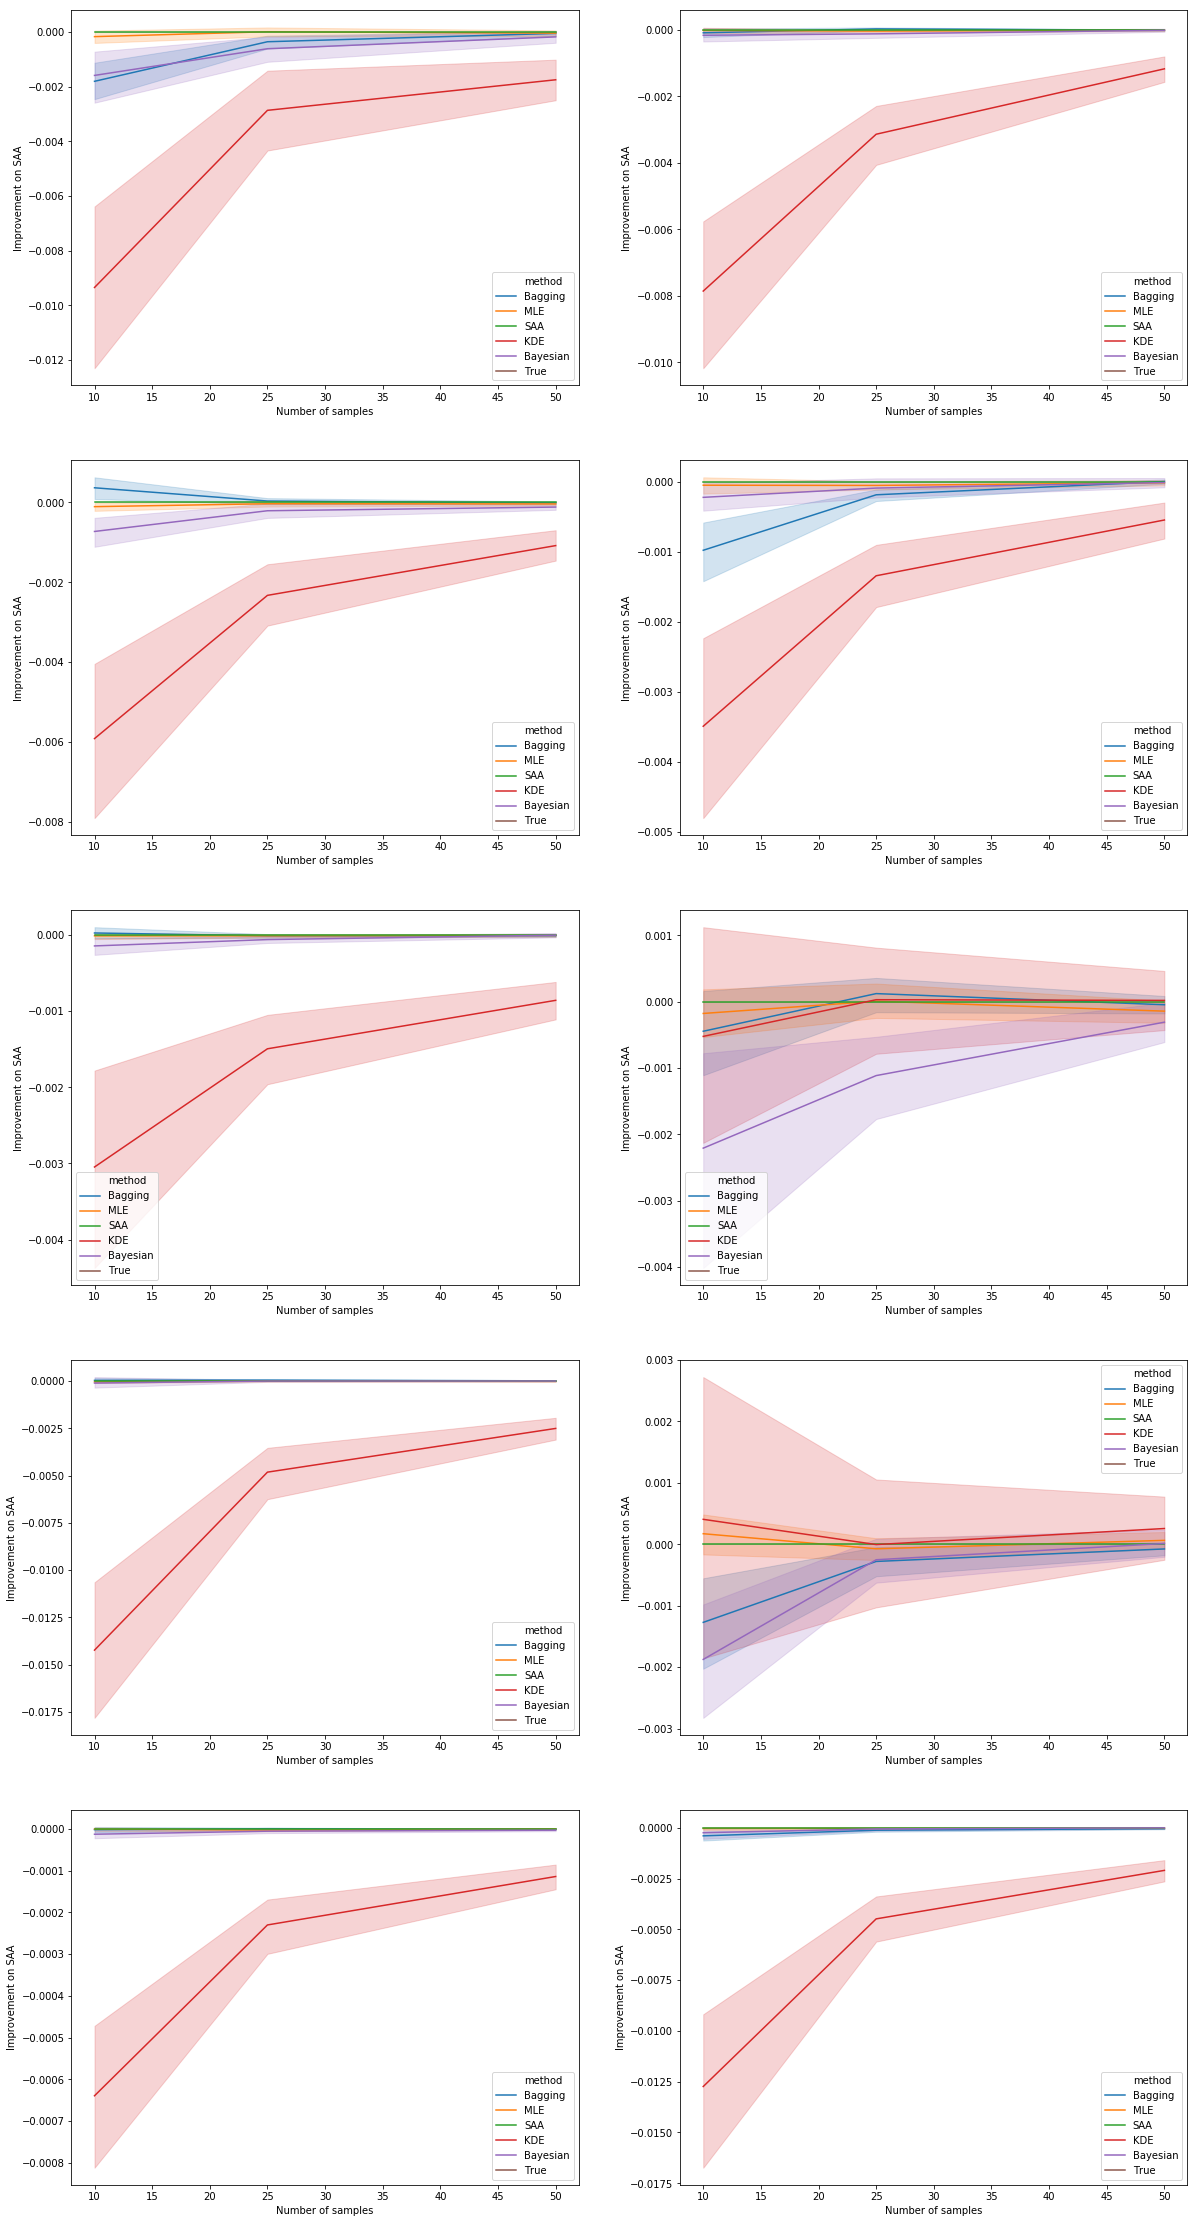

In [28]:
fig, axes = plt.subplots(5, 2,figsize=(20,40))
axes = axes.reshape(-1)
for i in range(len(chosen_functions)):
    #ax = fig.add_subplot(4, 5, i+1)
    df_valid = df[(df['function']==chosen_functions[i]+1)&((df["method"]!="True") |(df["method"]!="SAA"))]
    ax = sns.lineplot(x=df_valid['N'], y=df_valid['SAA_compare'], 
                      hue=df_valid['method'],ax=axes[i])
    
    df_valid = df[(df['function']==chosen_functions[i]+1)&(df['method']=="True")]
   # ax.plot(N,[df_valid['expected_cost'].iloc[0]]*len(N),
   #          color='brown',linestyle="--")
    #ax.set_title("Expected cost for function {0}".format(i+1))
    ax.set_ylabel("Improvement on SAA")
    ax.set_xlabel("Number of samples")

In [29]:
df_valid = df[((df["method"]!="True"))]

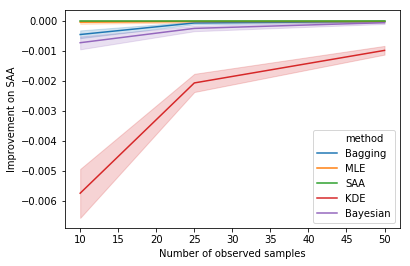

In [30]:
sns.lineplot(x=df_valid['N'], y=df_valid['SAA_compare'], 
                      hue=df_valid['method'])
plt.ylabel("Improvement on SAA")
plt.xlabel("Number of observed samples")
ax.set_xlim(10, 50)
plt.savefig("cost_function_avg_"+dist_type+"_saa_compare.png", bbox_inches = 'tight',
   pad_inches = 0)

In [31]:
df['true_compare'] = 0
for i in range(len(chosen_functions)):
    optimal = df[(df["method"]=="True") &(df["function"]==chosen_functions[i]+1)]["expected_cost"].values[0]
    mask = (df['function'] == chosen_functions[i]+1)
    df_valid = df[mask]
    df.loc[mask, 'true_compare'] = df_valid['expected_cost']-optimal

In [32]:
df["SAA_percent_improvement"] = 0
for i in np.arange(0,df.shape[0]-10,5):
    for k in range(5):
        if k!=2:
            df.loc[i+k,'SAA_percent_improvement'] = (1-
                                            df.loc[i+k,"true_compare"]/df.loc[i+2,"true_compare"]) 

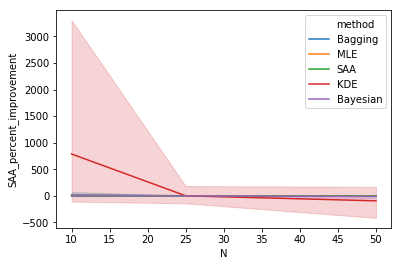

In [33]:
df_valid = df[((df["method"]!="True"))]
sns.lineplot(x=df_valid['N'], y=df_valid['SAA_percent_improvement'], 
                      hue=df_valid['method'])

In [70]:
np.argmax(df["SAA_percent_improvement"])

/home/harrison/.virtualenvs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


17528

In [71]:
df.iloc[17528]

w_star                      0.428297
method                           KDE
function                          19
N                                 25
distribution                   beta1
expected_cost                -0.0965
SAA_compare               -0.0103033
true_compare               0.0103029
SAA_percent_improvement      28664.2
Name: 17528, dtype: object

In [67]:
df.tail(20)

,w_star,method,function,N,distribution,expected_cost,SAA_compare,true_compare,SAA_percent_improvement
21410,0.396208,Bagging,19,25,beta1,-0.101985,-0.000382,0.004818,-0.086014
21411,0.394551,MLE,19,25,beta1,-0.102213,-0.000154,0.004590,-0.034774
21412,0.393404,SAA,19,25,beta1,-0.102367,0.000000,0.004436,0.000000
21413,0.498489,KDE,19,25,beta1,-0.077321,-0.025046,0.029482,-5.645948
21414,0.373587,Bayesian,19,25,beta1,-0.104615,0.002248,0.002188,0.506680
21415,0.238633,Bagging,19,50,beta1,-0.099032,-0.000459,0.007771,-0.062722
21416,0.236126,MLE,19,50,beta1,-0.098584,-0.000907,0.008219,-0.124036
21417,0.241273,SAA,19,50,beta1,-0.099491,0.000000,0.007312,0.000000
21418,0.296201,KDE,19,50,beta1,-0.105869,0.006378,0.000934,0.872253
21419,0.228978,Bayesian,19,50,beta1,-0.097236,-0.002254,0.009567,-0.308297
